In [11]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from mario.match import Mario # main object
from mario.match_utils import eval_matching_accuracy # for evaluating matching accuracy
from mario.match import pipelined_mario # for running the overall pipeline

# Exploratory analysis with subsampled data

*INSERT MORE DETAILS.* We use subsampled data to select hyperparameters, test for matchability, etc.
Also, need to explain the meanings of each argument

In [3]:
# import and subsample data
df1 = pd.read_csv("/Users/shuxiaochen/Dropbox/Research/ongoing/single-cell-integration/data-biology/drop_out_test/vaxaart-wb50k-cytof.csv")
df2 = pd.read_csv("/Users/shuxiaochen/Dropbox/Research/ongoing/single-cell-integration/data-biology/drop_out_test/wcctg-wb50k-cytof.csv")
np.random.seed(2667)
df1_sub = df1.iloc[np.random.choice(df1.shape[0], 1000, replace=False), :]
df2_sub = df2.iloc[np.random.choice(df2.shape[0], 2000, replace=False), :]

# extract cluster labels (not available in practice)
df1_labels = df1['cluster.info'].to_numpy()
df2_labels = df2['cluster.info'].to_numpy()
df1_sub_labels = df1_sub['cluster.info'].to_numpy()
df2_sub_labels = df2_sub['cluster.info'].to_numpy()

# remove non-numerical columns
df1 = df1.drop(['Unnamed: 0', 'cluster.info'], 1)
df2 = df2.drop(['Unnamed: 0', 'cluster.info'], 1)
df1_sub = df1_sub.drop(['Unnamed: 0', 'cluster.info'], 1)
df2_sub = df2_sub.drop(['Unnamed: 0', 'cluster.info'], 1)

## Initial matching with overlapping features

In [4]:
mario = Mario(df1_sub, df2_sub, normalization=True)

In [9]:
# compute distance matrix using overlapping features
_, singular_values = mario.compute_dist_ovlp(n_components=20)

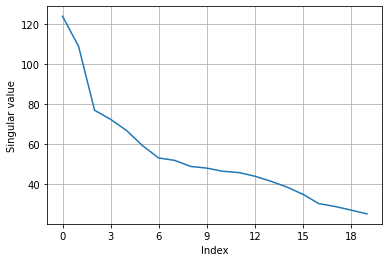

In [13]:
# visualize singular values to select n_components
fig, ax = plt.subplots()
ax.plot(list(range(len(singular_values))), singular_values)
ax.set(xlabel='Index', ylabel='Singular value')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

In [15]:
# any value above six looks good; let us choose 10
_ = mario.compute_dist_ovlp(n_components=10)

In [16]:
# specify how many cells in df2 should be matched to one cell in df1
mario.specify_matching_params(1)

In [17]:
# [optional] check the minimum valid sparsity level
mario.search_minimum_sparsity(mario.dist['ovlp'], slackness=1, init_sparsity=100, verbose=True)

If sparsity>=2000, then there is a valid matching; if sparsity<1, then there is no valid matching.
If sparsity>=100, then there is a valid matching; if sparsity<1, then there is no valid matching.
If sparsity>=50, then there is a valid matching; if sparsity<1, then there is no valid matching.
If sparsity>=25, then there is a valid matching; if sparsity<1, then there is no valid matching.
If sparsity>=25, then there is a valid matching; if sparsity<14, then there is no valid matching.
If sparsity>=19, then there is a valid matching; if sparsity<14, then there is no valid matching.
If sparsity>=19, then there is a valid matching; if sparsity<17, then there is no valid matching.
If sparsity>=18, then there is a valid matching; if sparsity<17, then there is no valid matching.


(17, 18)

In [18]:
# any a sparsity level >= 18 will give a valid matching 
# sparsity large <=> slower but potentially more accurate
# let us choose 100
_ = mario.match_cells('ovlp', sparsity=100, mode='auto')

In [22]:
# the zero-th entry = [1946] means the zero-th cell in df1 is matched to the 1946-th cell in df2
mario.matching['ovlp'][:10]

[[1946], [791], [1345], [163], [711], [967], [1884], [1543], [142], [297]]

In [23]:
# evaluate accuracy
eval_matching_accuracy(df1_sub_labels, df2_sub_labels, mario.matching['ovlp'], 'maj')

0.78

## Matching with all the features

In [24]:
# compute distance matrix using all the features
_, canonical_correlations = mario.compute_dist_all('ovlp', n_components=20)

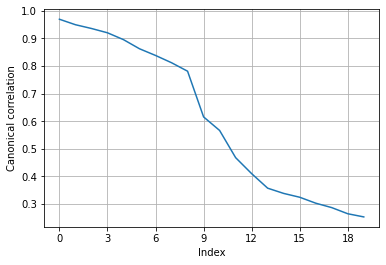

In [25]:
# visualize canonical correlations to select n_components
fig, ax = plt.subplots()
ax.plot(list(range(len(canonical_correlations))), canonical_correlations)
ax.set(xlabel='Index', ylabel='Canonical correlation')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

In [26]:
_, canonical_correlations = mario.compute_dist_all('ovlp', n_components=13)

In [28]:
_ = mario.match_cells('all', sparsity=None, mode='auto')

In [29]:
eval_matching_accuracy(df1_sub_labels, df2_sub_labels, mario.matching['all'], 'maj')

0.812

## Matchability test

In [30]:
mario.matchable(n_sim=20, top_k=5, flip_prob=0.3, subsample_prop=1, verbose=True)

Random sign flip, round 0...
Random sign flip, round 1...
Random sign flip, round 2...
Random sign flip, round 3...
Random sign flip, round 4...
Random sign flip, round 5...
Random sign flip, round 6...
Random sign flip, round 7...
Random sign flip, round 8...
Random sign flip, round 9...
Random sign flip, round 10...
Random sign flip, round 11...
Random sign flip, round 12...
Random sign flip, round 13...
Random sign flip, round 14...
Random sign flip, round 15...
Random sign flip, round 16...
Random sign flip, round 17...
Random sign flip, round 18...
Random sign flip, round 19...


(0.0, 0.0)

## Find the best interpolation

In [31]:
best_wt, _ = mario.interpolate(n_wts=10, top_k=5, verbose=True)

Now at iteration 0, wt=0.0
Now at iteration 1, wt=0.1111111111111111
Now at iteration 2, wt=0.2222222222222222
Now at iteration 3, wt=0.3333333333333333
Now at iteration 4, wt=0.4444444444444444
Now at iteration 5, wt=0.5555555555555556
Now at iteration 6, wt=0.6666666666666666
Now at iteration 7, wt=0.7777777777777777
Now at iteration 8, wt=0.8888888888888888
Now at iteration 9, wt=1.0


In [33]:
eval_matching_accuracy(df1_sub_labels, df2_sub_labels, mario.matching['wted'], 'maj')

0.809

## Filtering low-quality matched pairs

In [43]:
_  = mario.filter_bad_matches(
    'wted', n_clusters=10, n_components=10, bad_prop=0.2,
    max_iter=30, tol=1e-5, verbose=True
)

Now at iteration 0, current loss is 16.87351622626527.
Now at iteration 1, current loss is 16.553518406224608.
Now at iteration 2, current loss is 16.477772716642924.
Now at iteration 3, current loss is 16.45141082135822.
Now at iteration 4, current loss is 16.437889254208205.
Now at iteration 5, current loss is 16.42571003875791.
Now at iteration 6, current loss is 16.414374332784014.
Now at iteration 7, current loss is 16.402178768625934.
Now at iteration 8, current loss is 16.390138320776572.
Now at iteration 9, current loss is 16.377076756114576.
Now at iteration 10, current loss is 16.364734539793883.
Now at iteration 11, current loss is 16.359270882822095.
Now at iteration 12, current loss is 16.352390217297557.
Now at iteration 13, current loss is 16.34089474091267.
Now at iteration 14, current loss is 16.328455804893817.
Now at iteration 15, current loss is 16.291742275884413.
Now at iteration 16, current loss is 16.225952687692853.
Now at iteration 17, current loss is 16.19080

In [45]:
mario.matching['final']

[[613],
 [1987],
 [1345],
 [163],
 [1018],
 [967],
 [1922],
 [835],
 [1835],
 [883],
 [1605],
 [181],
 [558],
 [396],
 [388],
 [1914],
 [484],
 [438],
 [476],
 [1468],
 [983],
 [332],
 [1545],
 [838],
 [1850],
 [514],
 [],
 [336],
 [1255],
 [1216],
 [750],
 [689],
 [863],
 [736],
 [160],
 [281],
 [1797],
 [1554],
 [996],
 [1016],
 [88],
 [798],
 [],
 [306],
 [918],
 [960],
 [525],
 [1179],
 [624],
 [434],
 [],
 [177],
 [1745],
 [1517],
 [1437],
 [827],
 [506],
 [704],
 [1182],
 [],
 [1126],
 [1772],
 [1405],
 [1950],
 [714],
 [1048],
 [1511],
 [297],
 [1548],
 [548],
 [852],
 [754],
 [],
 [395],
 [786],
 [],
 [608],
 [1466],
 [],
 [1635],
 [1886],
 [1763],
 [292],
 [785],
 [797],
 [892],
 [78],
 [200],
 [473],
 [517],
 [615],
 [502],
 [1672],
 [1196],
 [470],
 [745],
 [51],
 [1154],
 [1055],
 [1039],
 [503],
 [259],
 [],
 [895],
 [1751],
 [1973],
 [252],
 [1109],
 [1770],
 [1871],
 [1354],
 [],
 [1477],
 [182],
 [805],
 [721],
 [646],
 [850],
 [901],
 [],
 [730],
 [466],
 [1946],
 [],


In [44]:
print('Matching accuracy is {}'.format(
    eval_matching_accuracy(df1_sub_labels, df2_sub_labels, mario.matching['final'], 'maj')
))
num_cells_remained = np.sum([1 for ii in range(mario.n1) if len(mario.matching['final'][ii]) != 0])
print("{}% cells remain.".format(num_cells_remained/mario.n1*100))

Matching accuracy is 0.8252747252747252
91.0% cells remain.


## k-NN matching

In [38]:
_ = mario.knn_matching('wted', k=5)

In [39]:
eval_matching_accuracy(df1_sub_labels, df2_sub_labels, mario.matching['knn'], 'maj')

0.857

## Joint embedding

In [42]:
_, cca = mario.fit_cca(mario.matching['final'], n_components=20, max_iter=10000)
df1_cca, df2_cca = cca.x_scores_, cca.y_scores_

# Overall pipeline using the full data

In [ ]:
final_matching_lst, knn_matching_lst, embedding_lst = pipelined_mario(
    data_lst=[df1, df2], normalization=True, n_batches=4,
    n_matched_per_cell=1, sparsity_ovlp=100, sparsity_all=None,
    n_components_ovlp=10, n_components_all=13,
    n_cancor=5, n_wts=10,
    n_clusters=10, n_components_filter=10, bad_prop=0.2, max_iter_filter=20,
    knn=5, embed_dim=20, max_iter_embed=500, save_path='../data', verbose=False
)

In [ ]:
eval_matching_accuracy(df1_labels, df2_labels, final_matching_lst[1], 'maj')